# 9-Qubit Error Correcting Code


#### In this notebook, we will show the functionality of the First Full Quantum Code.
#### We will refer back to the 3-Qubit Code, as the 9-Qubit Code is a repetition code.

In [1]:
import numpy as np

from qec_helpers import *
# Importing required libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace

import random
from qiskit.extensions import UnitaryGate



# Visualization of circuits: Initializing backend simulators
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')



env: QISKIT_SETTINGS={}


In [2]:
# Initializing the Pauli operators
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,1j],[-1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_I = np.identity(2)
print('Below we show the Pauli Operators which can be used to describe any quantum gate on an individual qubit:')
print('Pauli-X: \n', sigma_x) 
print('Pauli-Y: \n', sigma_y)
print('Pauli-Z: \n', sigma_z)
print('Pauli-I: \n', sigma_I)

Below we show the Pauli Operators which can be used to describe any quantum gate on an individual qubit:
Pauli-X: 
 [[0 1]
 [1 0]]
Pauli-Y: 
 [[ 0.+0.j  0.+1.j]
 [-0.-1.j  0.+0.j]]
Pauli-Z: 
 [[ 1  0]
 [ 0 -1]]
Pauli-I: 
 [[1. 0.]
 [0. 1.]]


## 3 Qubit Code Review

#### The 3 Qubit Code was shown to only be able to correct $\sigma_x$ (Bit-Flip) Errors
#### Only able to correct for one type of error at a time


### For $\sigma_z$ (Phase-Flip) Errors, does the error detection circuit signal an error?
#### We can build a circuit that detects phase-flip instead of bit-flip errors,
#### by instead encoding the qubits in a GHZ state in the $|±\rangle$ basis:
$\alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|+ + +\rangle + 
\beta|− − −\rangle $



### Gate Operations Review ( CX and CZ ):



#### The CNOT gate is typically used to establish entanglement between qubits and implement controlled operations. 


#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


#### The CZ gate, also known as the HGZ gate, is a two-qubit gate that introduces a phase shift of $\pi$ to the qubit state. 
#### Phase Shift: Refers to a change in the timing or alignment of a wave or oscillation. 


#### The Z gate is represented by the following matrix: $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}$$



####  When applied to the $\vert0\rangle$ state, 
$$Z\vert0\rangle = \vert0\rangle$$

#### However, when applied to the $\vert1\rangle$ state, the Z gate introduces a phase shift of $\pi$ (or a phase flip) to the state.  
$$Z\vert1\rangle = -\vert1\rangle$$





### Foundations of Correction

#### This algorithm a single logical qubit,  encoded using 9 physical qubits.
#### Able to correct for both a single $\sigma_x$ error per block of 3 Qubits (bit flip) 
#### and for a $\sigma_z$ (phase-flip). 

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $|0\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right)$ and
$|1\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right)$ and $\vert1\rangle_L = \vert111\rangle$

#### A single qubit state is still represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$




#### Below we show the quantum circuit for encoding a single logical qubit in a 9-qubit system.

## Implementing for $\sigma_x$ correction: Logical state of a 9 Qubit Code

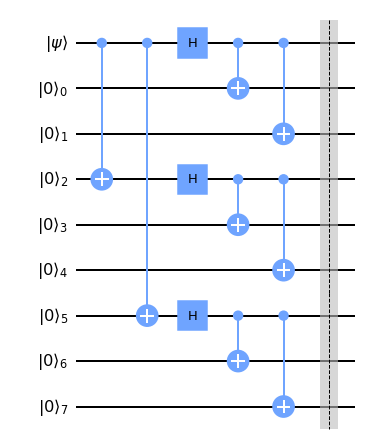

In [3]:

psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')

qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 3)
qc.cnot(0, 6)
qc.h(0)
qc.h(3)
qc.h(6)
qc.cnot(0, 1)
qc.cnot(3, 4)
qc.cnot(6, 7)
qc.cnot(0, 2)
qc.cnot(3, 5)
qc.cnot(6, 8)
qc.barrier()

qc.draw()
 

    
 

In [ ]:

hadamard = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
cnot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
def non_adj_CNOT(control, target, tot_qubits):
    p = target - control
    all_dots = []

    for j in range(p):
        next_dot = np.kron(np.identity(2 ** j), np.kron(cnot, np.identity(2 ** (p - j - 1))))
        all_dots.append(next_dot)

    gate = all_dots[0]
    for j in range(1, p):
        gate = np.dot(gate, all_dots[j])

    final_gate = np.dot(gate, gate)
    n1 = control
    n2 = tot_qubits - target - 1
    final_total_gate = np.kron(np.identity(2 ** n1), np.kron(final_gate, np.identity(2 ** n2)))

    return final_total_gate


def vector_state_to_bit_state(vector_state, num_qubits):
    bit_representation = [format(i, '0' + str(num_qubits) + 'b') for i in range(2 ** num_qubits)]
    return bit_representation, vector_state.flatten()


def nine_qubit_initialize_logical_state(initial_psi):
    initial_ancilla_state = np.array([1, 0])
    psi = initial_psi
    

    initial_logical_state = np.kron(psi, np.kron(initial_ancilla_state, np.identity(2 ** 8)))

    non_adj_CNOT_psi_qthree = non_adj_CNOT(0, 3, 9)
    non_adj_CNOT_psi_qsix = non_adj_CNOT(0, 6, 9)

    hadamard_psi = np.kron(np.identity(2), hadamard)
    hadamard_three = np.kron(np.identity(2 ** 2), hadamard)
    hadamard_six = np.kron(np.identity(2 ** 5), hadamard)

    cnot_psi_qone = np.kron(cnot, np.identity(2 ** 6))
    cnot_qthree_qfour = np.kron(np.identity(2), cnot)
    cnot_qsix_qseven = np.kron(np.identity(2 ** 2), cnot)

    non_adj_CNOT_psi_qtwo = non_adj_CNOT(0, 2, 9)
    non_adj_CNOT_qthree_qfive = non_adj_CNOT(3, 5, 9)
    non_adj_CNOT_qsix_qeight = non_adj_CNOT(6, 8, 9)

    final_logical_state = np.dot(
        np.kron(non_adj_CNOT_qsix_qeight, np.kron(
            non_adj_CNOT_qthree_qfive, np.kron(non_adj_CNOT_psi_qtwo, np.kron(
                cnot_qsix_qseven, np.kron(cnot_qthree_qfour, np.kron(
                    cnot_psi_qone, np.kron(hadamard_six, np.kron(
                        hadamard_three, np.kron(hadamard_psi, np.kron(
                            non_adj_CNOT_psi_qsix, non_adj_CNOT_psi_qthree)
                        ))
                    ))
                ))
            ))
        )), initial_logical_state

    return final_logical_state, psi


# Example usage
initial_psi = np.array([0, 1])
final_logical_state, psi = nine_qubit_initialize_logical_state(initial_psi)
k = 9  # Number of qubits in the reduced system

bit_representation, reduced_logical_state = vector_state_to_bit_state(final_logical_state, k)

print('Psi State:', psi)
print('Final Logical State:', final_logical_state)
print('Bit Representation:', bit_representation)
print('Reduced Logical State:', reduced_logical_state)


## Initializing for our Phase Correction

### 9 Qubit Phase Flip Error Detection & Correction




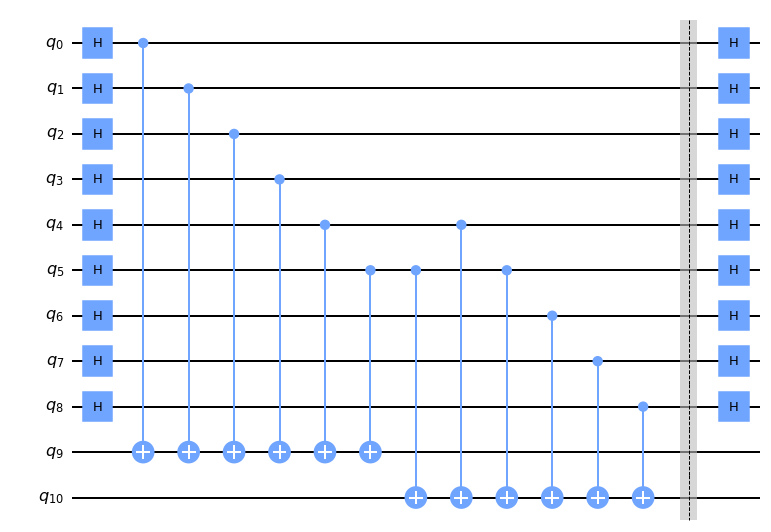

In [4]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')
additional_ancilla = QuantumRegister(10, '|0⟩')
qc = QuantumCircuit(11)

# Hadamard gates on the left side (vertical arrangement)
for i in range(9):
    qc.h(i)

# Define the Z error correction circuit for Shor's code
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(2, 9)
qc.cx(3, 9)
qc.cx(4, 9)
qc.cx(5, 9)

qc.cx(5, 10)
qc.cx(4, 10)
qc.cx(5, 10)
qc.cx(6, 10)
qc.cx(7, 10)
qc.cx(8, 10)

# Add barrier gate after the error correction circuit
qc.barrier()

# Hadamard gates on the right side (vertical arrangement)
for i in range(9):
    qc.h(i)
qc.draw()



In [ ]:


def apply_random_z_error(logical_state):
    error_index = random.randint(0, 8)
    error_state = np.copy(logical_state)
    error_state[error_index] *= -1
    return error_state, error_index

def apply_defined_z_error(logical_state, error_index):
    error_state = np.copy(logical_state)
    error_state[error_index] *= -1
    return error_state, error_index

# Example usage
logical_state = np.zeros(2**9)
logical_state[0] = 1  # Initialize the logical state to |0...0>

# Apply random Z error to one of the qubits
errored_state, error_qubit = apply_random_z_error(logical_state)
print('Logical State without the random Z error:', logical_state.astype(int))
print('Logical State with the random Z error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)

# Apply defined Z error to one of the qubits
error_index = 4
errored_state, error_qubit = apply_defined_z_error(logical_state, error_index)
print('Logical State without the defined Z error:', logical_state.astype(int))
print('Logical State with the defined Z error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)


In [5]:
# Afteri initializing the 9-qubit logical state with the additional ancillas, 
#we will apply a random Phase error to one of the qubits.

def apply_random_x_error(logical_state):
    error_index = random.randint(0, 8)
    error_state = np.copy(logical_state)
    error_state[error_index] = 1 - error_state[error_index]
    return error_state, error_index

def apply_defined_x_error(logical_state, error_index):
    error_state = np.copy(logical_state)
    error_state[error_index] = 1 - error_state[error_index]
    return error_state, error_index

# Example usage
logical_state = np.zeros(2**9)
logical_state[0] = 1  # Initialize the logical state to |0...0>

# Apply random X error to one of the qubits
errored_state, error_qubit = apply_random_x_error(logical_state)
print('Logical State without the random X error:', logical_state.astype(int))
print('Logical State with the random X error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)

# Apply defined X error to one of the qubits
error_index = 4
errored_state, error_qubit = apply_defined_x_error(logical_state, error_index)
print('Logical State without the defined X error:', logical_state.astype(int))
print('Logical State with the defined X error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)
# After we have initialized the 9-qubit logical state, we will apply a random error to one of the qubits.

NameError: name 'final_logical_state' is not defined

In [10]:
import numpy as np
import random

def apply_pauli_X(qubit_index, num_qubits):
    pauli_X_matrix = np.array([[0, 1], [1, 0]])
    gate = np.identity(2)
    for _ in range(num_qubits - 1):
        gate = np.kron(gate, np.identity(2))
    gate[qubit_index][qubit_index] = pauli_X_matrix[0][0]
    gate[qubit_index][qubit_index + 1] = pauli_X_matrix[0][1]
    gate[qubit_index + 1][qubit_index] = pauli_X_matrix[1][0]
    gate[qubit_index + 1][qubit_index + 1] = pauli_X_matrix[1][1]
    return gate

def apply_pauli_Z(qubit_index, num_qubits):
    pauli_Z_matrix = np.array([[1, 0], [0, -1]])
    gate = np.identity(2)
    for _ in range(num_qubits - 1):
        gate = np.kron(gate, np.identity(2))
    gate[qubit_index][qubit_index] = pauli_Z_matrix[0][0]
    gate[qubit_index][qubit_index + 1] = pauli_Z_matrix[0][1]
    gate[qubit_index + 1][qubit_index] = pauli_Z_matrix[1][0]
    gate[qubit_index + 1][qubit_index + 1] = pauli_Z_matrix[1][1]
    return gate

def nine_qubit_random_qubit_x_error(logical_state):
    error_index = random.randint(0, 8)
    error_gate = apply_pauli_X(error_index, 9)
    errored_logical_state = np.dot(error_gate, logical_state)
    return errored_logical_state, error_index

def nine_qubit_defined_qubit_x_error(logical_state, error_index):
    error_gate = apply_pauli_X(error_index, 9)
    errored_logical_state = np.dot(error_gate, logical_state)
    return errored_logical_state, error_index

def nine_qubit_random_qubit_z_error(logical_state):
    error_index = random.randint(0, 8)
    error_gate = apply_pauli_Z(error_index, 9)
    errored_logical_state = np.dot(error_gate, logical_state)
    return errored_logical_state, error_index

def nine_qubit_defined_qubit_z_error(logical_state, error_index):
    error_gate = apply_pauli_Z(error_index, 9)
    errored_logical_state = np.dot(error_gate, logical_state)
    return errored_logical_state, error_index

# Example usage
logical_state = np.zeros(2 ** 9)
logical_state[0] = 1  # Initialize the logical state to |0...0>

# Apply random X error to one of the qubits
errored_state, error_qubit = nine_qubit_random_qubit_x_error(logical_state)
print('Logical State without the random X error:', logical_state.astype(int))
print('Logical State with the random X error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)

# Apply defined X error to one of the qubits
error_index = 4
errored_state, error_qubit = nine_qubit_defined_qubit_x_error(logical_state, error_index)
print('Logical State without the defined X error:', logical_state.astype(int))
print('Logical State with the defined X error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)

# Apply random Z error to one of the qubits
errored_state, error_qubit = nine_qubit_random_qubit_z_error(logical_state)
print('Logical State without the random Z error:', logical_state.astype(int))
print('Logical State with the random Z error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)

# Apply defined Z error to one of the qubits
error_index = 7
errored_state, error_qubit = nine_qubit_defined_qubit_z_error(logical_state, error_index)
print('Logical State without the defined Z error:', logical_state.astype(int))
print('Logical State with the defined Z error:', errored_state.astype(int))
print('The error occurred at qubit:', error_qubit)



Enter the input state (e.g., '0 1'): 0
Enter the number of bit flip errors: 1


ValueError: shapes (512,512) and (4,1) not aligned: 512 (dim 1) != 4 (dim 0)

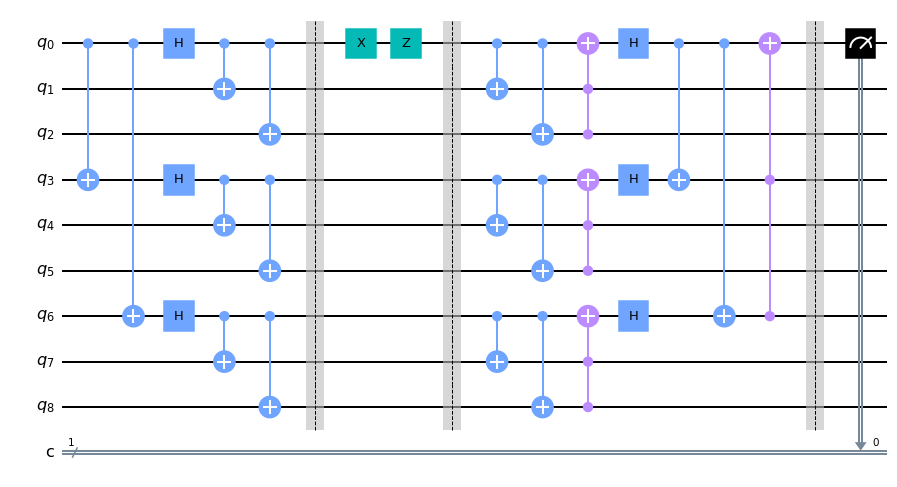

In [11]:
#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
#circuit.x(q[5])#Bit flip error
#circuit.x(q[8])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw()